In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def load_data(file):
    df = pd.read_csv(os.path.join("data", file))
    return df

df = load_data("train.csv")


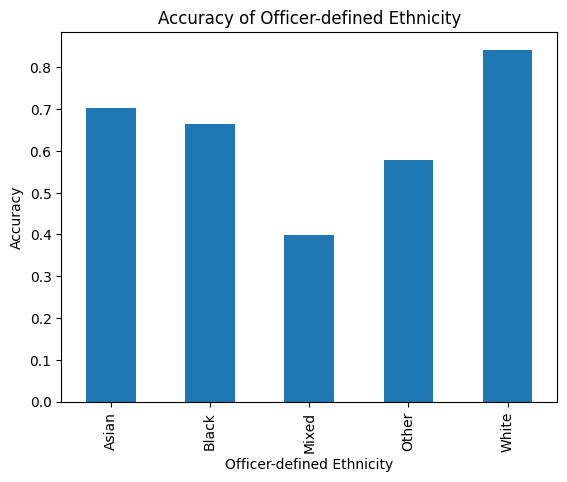

In [2]:
def map_self_defined_to_officer_defined(df):
    ethnicity_map = {
        'White - English/Welsh/Scottish/Northern Irish/British': 'White',
        'White - Irish': 'White',
        'White - Any other White background': 'White',
        'Mixed/Multiple ethnic groups - White and Black Caribbean': 'Mixed',
        'Mixed/Multiple ethnic groups - White and Black African': 'Mixed',
        'Mixed/Multiple ethnic groups - White and Asian': 'Mixed',
        'Mixed/Multiple ethnic groups - Any other Mixed/Multiple ethnic background': 'Mixed',
        'Asian/Asian British - Indian': 'Asian',
        'Asian/Asian British - Pakistani': 'Asian',
        'Asian/Asian British - Bangladeshi': 'Asian',
        'Asian/Asian British - Any other Asian background': 'Asian',
        'Black/African/Caribbean/Black British - African': 'Black',
        'Black/African/Caribbean/Black British - Caribbean': 'Black',
        'Black/African/Caribbean/Black British - Any other Black/African/Caribbean background': 'Black',
        'Other ethnic group - White and Black African': 'Mixed',
        'Other ethnic group - White and Black Caribbean': 'Mixed',
        'Other ethnic group - Any other ethnic group': 'Other',
        'Other ethnic group - Not stated': 'Other',
        'Other ethnic group - Arab': 'Other',
        'White - Gypsy or Irish Traveller': 'White'
    }
    
    df['Mapped ethnicity'] = df['Self-defined ethnicity'].map(ethnicity_map)
    
    return df


df_map = df.copy()
df = map_self_defined_to_officer_defined(df)

correct_predictions = df[df['Mapped ethnicity'] == df['Officer-defined ethnicity']]
total_predictions = df.groupby('Officer-defined ethnicity').size()


accuracy = correct_predictions.groupby('Officer-defined ethnicity').size() / total_predictions

accuracy.plot(kind='bar')
plt.title('Accuracy of Officer-defined Ethnicity')
plt.xlabel('Officer-defined Ethnicity')
plt.ylabel('Accuracy')
plt.show()



In [3]:
accuracy

Officer-defined ethnicity
Asian    0.702133
Black    0.663726
Mixed    0.399868
Other    0.577269
White    0.842437
dtype: float64

In [4]:
threshold = 30
print(df.shape)
# Create a new dataframe that only includes data that meets the threshold criteria
df = df.groupby(['station', 'Officer-defined ethnicity','Gender']).filter(lambda x : x['observation_id'].count() >= 30 )
#print(bla.shape)


(856610, 17)


In [5]:
#df = df.groupby(['Officer-defined ethnicity','Gender','Age range']).filter(lambda x : x['observation_id'].count() >= 5 )


# Ethnicity 

In [6]:
df_et = df.drop(df[df['station'].isin(['humberside', 'lancashire','metropolitan','west-midlands','leicestershire'])].index)
df_et.loc[ df_et['Outcome'] == 'A no further action disposal', 'Outcome linked to object of search'] = False


## removal of clothing 

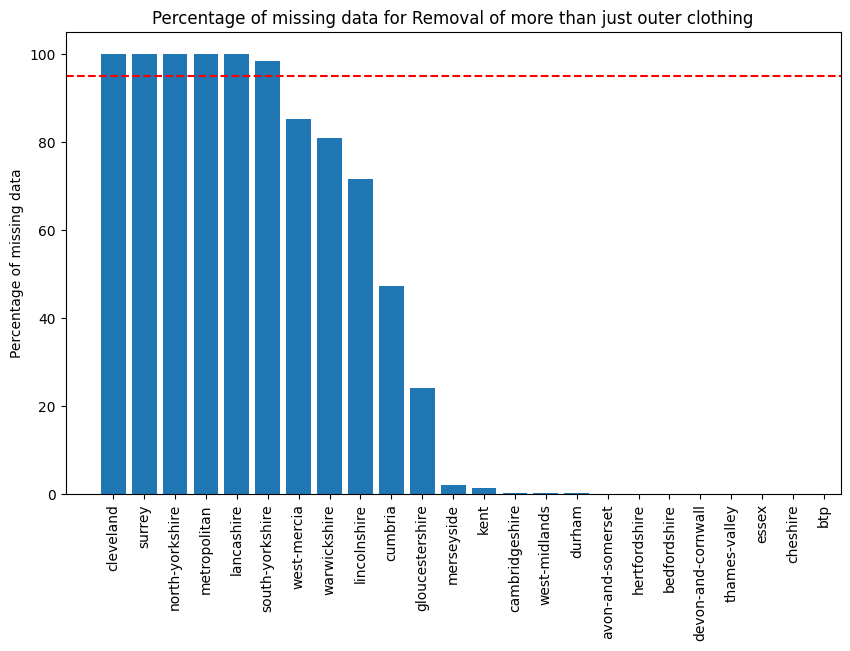

In [7]:
# Calculate the percentage of missing data for each station
missing_perc = df[df['Removal of more than just outer clothing'].isna()].groupby('station').size() / df.groupby('station').size() * 100

# Sort the stations by percentage of missing data
missing_perc = missing_perc.sort_values(ascending=False)

# Create the bar plot
plt.figure(figsize=(10, 6))
plt.bar(x=missing_perc.index, height=missing_perc.values)
plt.xticks(rotation=90)
plt.ylabel('Percentage of missing data')
plt.title('Percentage of missing data for Removal of more than just outer clothing')

# Add a horizontal line at 95%
plt.axhline(y=95, color='r', linestyle='--')

plt.show()

In [8]:
# Find stations where the "Outcome linked to object of search" is completely missing
df_new = df.drop(df[df['station'].isin(['humberside', 'lancashire','metropolitan','west-midlands','leicestershire'])].index)

df_new.loc[ df_new['Outcome'] == 'A no further action disposal', 'Outcome linked to object of search'] = False

stations_to_drop = df_new[df_new.groupby('station')['Removal of more than just outer clothing'].transform('count')==0]['station'].unique()

# Drop the stations from the dataframe
df_rc1 = df_new[~df_new['station'].isin(stations_to_drop)]
print("The stations droped were:",stations_to_drop)
print('humberside', 'lancashire','metropolitan','west-midlands',"leicestershire")

The stations droped were: ['surrey' 'north-yorkshire' 'cleveland']
humberside lancashire metropolitan west-midlands leicestershire


In [9]:
def clean_RC (df):
    
    df_ = df.copy()
    
    #df_= df_[['Officer-defined ethnicity',"Gender","Age range","station","Removal of more than just outer clothing","Outcome"]]
    
    success_outcomes = ['Community resolution', 'Khat or Cannabis warning', 'Caution (simple or conditional)', 
                    'Arrest', 'Penalty Notice for Disorder', 'Summons / charged by post', 
                    'Suspect arrested', 'Suspect summoned to court']
    
    #df_= df_[df_['Gender']=="Female"]
    
    # Remove rows where age range is 'under 10'
    
    df_ = df_[df_['Age range'] != 'under 10']

    # Remove rows where gender is 'Other'
    df_ = df_[df_['Gender'] != 'Other']
    

    # Drop the stations from the dataframe
    #df_ = df_[~df_['station'].isin(stations_to_drop)]


    df_['Outcome linked to object of search'] = df_['Outcome linked to object of search'].fillna(False)
    df_['Removal of more than just outer clothing'] = df_['Removal of more than just outer clothing'].fillna(False)
    df_['success'] = df_.apply(lambda x: 1 if x['Outcome'] in success_outcomes and x['Outcome linked to object of search'] == True else 0, axis=1)
    
    
    
    return df_

df_rc = clean_RC(df_rc1)


In [10]:
# Subset the data for searches where outer clothing was removed
df_outer = df_rc[df_rc['Removal of more than just outer clothing'] == True]

# Compute the success rates separately for females and males
success_rate_female = df_outer[df_outer['Gender'] == 'Female']['success'].mean()
success_rate_male = df_outer[df_outer['Gender'] == 'Male']['success'].mean()

print(f"Success rate when outer clothing was removed for female suspects: {success_rate_female:.2%}")
print(f"Success rate when outer clothing was removed for male suspects: {success_rate_male:.2%}")


Success rate when outer clothing was removed for female suspects: 21.69%
Success rate when outer clothing was removed for male suspects: 31.46%


In [11]:
# Compute the success rate for each officer-defined ethnicity
ethnicities = df_outer['Officer-defined ethnicity'].unique()
for ethnicity in ethnicities:
    success_rate = df_outer[df_outer['Officer-defined ethnicity'] == ethnicity]['success'].mean()
    print(f"Success rate when outer clothing was removed for {ethnicity}: {success_rate:.2%}")


Success rate when outer clothing was removed for White: 30.38%
Success rate when outer clothing was removed for Black: 31.03%
Success rate when outer clothing was removed for Other: 35.35%
Success rate when outer clothing was removed for Asian: 27.26%
Success rate when outer clothing was removed for Mixed: 31.48%


In [12]:
df_outer = df_rc[(df_rc['Removal of more than just outer clothing'] == True)& (df_rc['Gender'] == 'Female') ]
# Compute the success rate for each officer-defined ethnicity
ethnicities = df_outer['Officer-defined ethnicity'].unique()
for ethnicity in ethnicities:
    success_rate = df_outer[df_outer['Officer-defined ethnicity'] == ethnicity]['success'].mean()
    print(f"Success rate when outer clothing was removed for {ethnicity}: {success_rate:.2%}")

    

Success rate when outer clothing was removed for Other: 44.44%
Success rate when outer clothing was removed for White: 21.13%
Success rate when outer clothing was removed for Asian: 27.27%
Success rate when outer clothing was removed for Black: 25.42%
Success rate when outer clothing was removed for Mixed: 35.71%


In [13]:
df_outer_success = df_outer[df_outer['success'] == 1]

success_rate = len(df_outer_success) / len(df_outer)
print("Success rate:", success_rate)

median_success_rate = df_outer['success'].median()
print("Median success rate:", median_success_rate)


Success rate: 0.21693491952414276
Median success rate: 0.0


## if join ages and ethnicities 

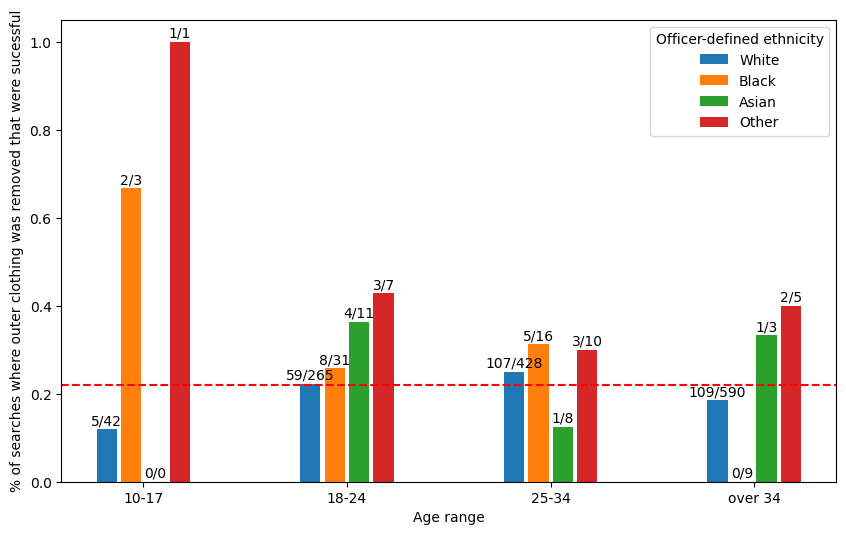

In [14]:
import pandas as pd

df_combined_age = df_rc.copy()
df_combined_age['Officer-defined ethnicity'] = df_combined_age['Officer-defined ethnicity'].replace(['Mixed', 'Other'], 'Other')

df_females = df_combined_age[(df_combined_age['Gender'] == 'Female') & (df_combined_age['Removal of more than just outer clothing'] == True) ]

age_ranges = ['10-17','18-24', '25-34', 'over 34']
ethnicities = ['White', 'Black','Asian','Other']

# create a figure and axis object
fig, ax = plt.subplots(figsize=(10, 6))

# set the bar width and gap between the bars
width = 0.1
gap = 0.02

# loop through each ethnicity and plot the bars for each age range
for i, ethnicity in enumerate(ethnicities):
    # get the subset of data for the current ethnicity
    ethnicity_data = df_females[df_females['Officer-defined ethnicity'] == ethnicity]
    # create a list to store the success rates for each age range
    text_list=[]
    success_rates = []
    for age_range in age_ranges:
        # get the subset of data for the current age range
        age_data = ethnicity_data[ethnicity_data['Age range'] == age_range]
        # filter the data for successful searches where "Removal of more than just outer clothing" is True
        success_data = age_data[(age_data['success'] == 1)]
        # calculate the success rate for the current age range and ethnicity
        success_rate = success_data.shape[0] / age_data.shape[0] if age_data.shape[0] > 0 else 0
        success_rates.append(success_rate)
        
        text = f'{success_data.shape[0]}/{age_data.shape[0]}'
        text_list.append(text)
        #print(text)
        
    # plot the bars for the current ethnicity and age range
    x_pos = np.arange(len(age_ranges)) + i * (width + gap)
    ax.bar(x_pos, success_rates, width=width, label=ethnicity)
    # add the success rate text on top of each bar
    for j, sr in enumerate(success_rates):
        ax.text(x_pos[j], sr+0.01, text_list[j] , ha='center')
        
        


# add the red line and the x and y axis labels and the legend
ax.axhline(y=0.22, color='red', linestyle='--')

ax.set_xlabel('Age range')
ax.set_ylabel('% of searches where outer clothing was removed that were sucessful')
ax.set_xticks(np.arange(len(age_ranges)) + ((len(ethnicities) - 1) / 2) * (width + gap))
ax.set_xticklabels(age_ranges)
ax.legend(title='Officer-defined ethnicity', loc='upper right')

# show the plot
plt.show()


# without the join

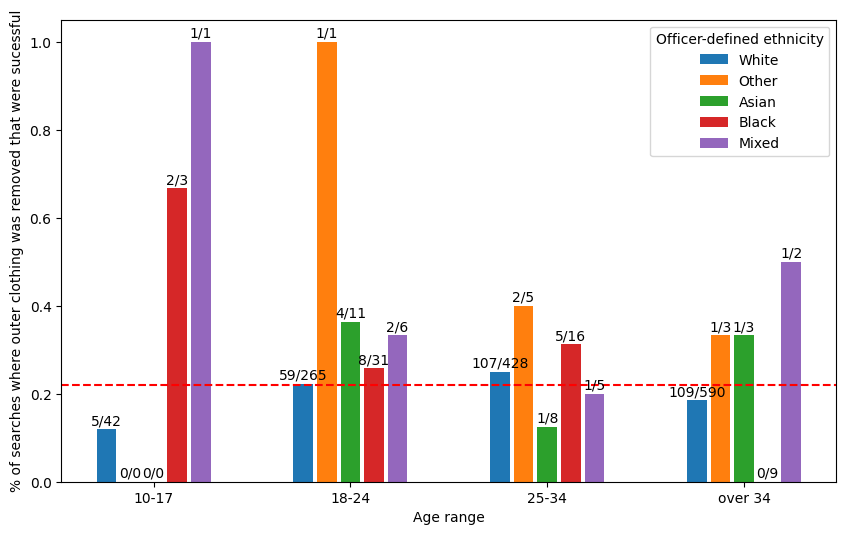

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# filter the data for females only
df_females = df_rc[(df_rc['Gender'] == 'Female') & (df_rc['Removal of more than just outer clothing'] == True) ]

# define the age ranges and officer-defined ethnicity values
age_ranges = ['10-17', '18-24', '25-34', 'over 34']
ethnicities = ['White', 'Other', 'Asian', 'Black', 'Mixed']

# create a figure and axis object
fig, ax = plt.subplots(figsize=(10, 6))

# set the bar width and gap between the bars
width = 0.1
gap = 0.02

# loop through each ethnicity and plot the bars for each age range
for i, ethnicity in enumerate(ethnicities):
    # get the subset of data for the current ethnicity
    ethnicity_data = df_females[df_females['Officer-defined ethnicity'] == ethnicity]
    # create a list to store the success rates for each age range
    success_rates = []
    text_list=[]
    for age_range in age_ranges:
        # get the subset of data for the current age range
        age_data = ethnicity_data[ethnicity_data['Age range'] == age_range]
        # filter the data for successful searches where "Removal of more than just outer clothing" is True
        success_data = age_data[(age_data['success'] == 1)]
        # calculate the success rate for the current age range and ethnicity
        success_rate = success_data.shape[0] / age_data.shape[0] if age_data.shape[0] > 0 else 0
        success_rates.append(success_rate)
        text = f'{success_data.shape[0]}/{age_data.shape[0]}'
        text_list.append(text)
    # plot the bars for the current ethnicity and age range
    x_pos = np.arange(len(age_ranges)) + i * (width + gap)
    ax.bar(x_pos, success_rates, width=width, label=ethnicity)
    
    for j, sr in enumerate(success_rates):
        ax.text(x_pos[j], sr+0.01, text_list[j] , ha='center')

ax.axhline(y=0.22, color='red', linestyle='--')
# add the x and y axis labels and the legend
ax.set_xlabel('Age range')
ax.set_ylabel('% of searches where outer clothing was removed that were sucessful')
ax.set_xticks(np.arange(len(age_ranges)) + ((len(ethnicities) - 1) / 2) * (width + gap))
ax.set_xticklabels(age_ranges)
ax.legend(title='Officer-defined ethnicity', loc='upper right')

# show the plot
plt.show()



In [16]:
import pandas as pd

# create a subset of the original data for non-white individuals only
df_nonwhite = df_females[~df_females['Officer-defined ethnicity'].isin(['White'])]

# get the top 15 police stations with the most removal of outer clothing on non-white individuals
top_stations = df_nonwhite.groupby('station')['Removal of more than just outer clothing'].sum().nlargest(15).index.tolist()

# create a new dataframe to store the success rates
df_success_rates = pd.DataFrame(columns=['Station', 'Officer-defined ethnicity', 'Success rate'])

# loop through each police station and officer-defined ethnicity to calculate the success rate
for station in top_stations:
    # create a subset of the data for the current police station
    df_station = df_nonwhite[df_nonwhite['station'] == station]
    for ethnicity in df_station['Officer-defined ethnicity'].unique():
        # create a subset of the data for the current ethnicity
        df_ethnicity = df_station[df_station['Officer-defined ethnicity'] == ethnicity]
        # calculate the success rate for the current police station and ethnicity
        success_rate = df_ethnicity['success'].sum() / df_ethnicity.shape[0] if df_ethnicity.shape[0] > 0 else 0
        # add the success rate to the dataframe
        df_success_rates = df_success_rates.append({'Station': station,
                                                      'Officer-defined ethnicity': ethnicity,
                                                      'Success rate': success_rate},
                                                     ignore_index=True)

# display the success rates by police station and officer-defined ethnicity
print(df_success_rates)



               Station Officer-defined ethnicity  Success rate
0        hertfordshire                     Asian      0.333333
1        hertfordshire                     Black      0.222222
2    avon-and-somerset                     Mixed      0.500000
3    avon-and-somerset                     Black      0.222222
4            hampshire                     Other      0.800000
5            hampshire                     Black      0.500000
6            hampshire                     Asian      0.000000
7                 kent                     Mixed      0.166667
8                 kent                     Black      0.000000
9                 kent                     Asian      0.000000
10      west-yorkshire                     Asian      0.333333
11      west-yorkshire                     Black      0.000000
12              sussex                     Black      0.333333
13       thames-valley                     Asian      0.500000
14       thames-valley                     Black      0

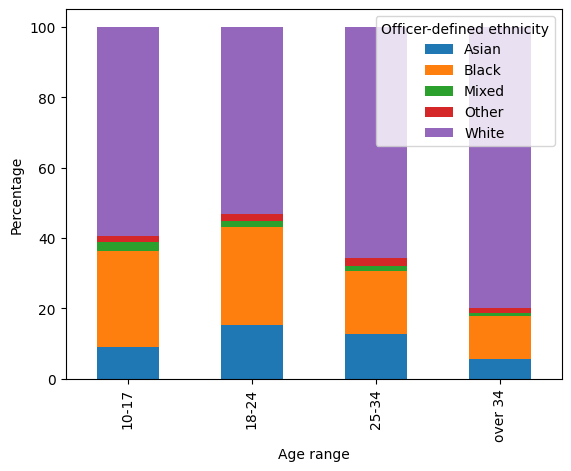

In [17]:
# Calculate the total number of observations per age range
df_males = df_rc[(df_rc['Gender'] == 'Male') & (df_rc['Removal of more than just outer clothing'] == True) ]
total_per_age = df_males.groupby(['Age range'])['observation_id'].count()

# Create a new dataframe to store the percentage of each ethnicity within each age range
df_perc = pd.DataFrame(columns=['Age range', 'Officer-defined ethnicity', 'Percentage'])

# Calculate the percentage of each ethnicity within each age range and store it in the new dataframe
for age_range in df_males['Age range'].unique():
    df_age_range = df_males[df_males['Age range'] == age_range]
    total_per_ethnicity = df_age_range.groupby(['Officer-defined ethnicity'])['observation_id'].count()
    for ethnicity in total_per_ethnicity.index:
        perc = total_per_ethnicity[ethnicity] / total_per_age[age_range] * 100
        df_perc = df_perc.append({'Age range': age_range, 'Officer-defined ethnicity': ethnicity, 'Percentage': perc}, ignore_index=True)

# Pivot the dataframe to create a plot
df_plot = df_perc.pivot(index='Age range', columns='Officer-defined ethnicity', values='Percentage')

# Plot the data
ax = df_plot.plot(kind='bar', stacked=True)
ax.set_ylabel('Percentage')
ax.set_xlabel('Age range')
plt.show()



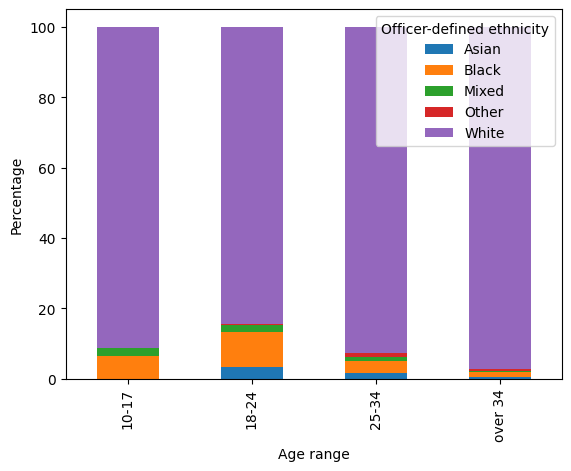

In [18]:
# Calculate the total number of observations per age range
total_per_age = df_females.groupby(['Age range'])['observation_id'].count()

# Create a new dataframe to store the percentage of each ethnicity within each age range
df_perc = pd.DataFrame(columns=['Age range', 'Officer-defined ethnicity', 'Percentage'])

# Calculate the percentage of each ethnicity within each age range and store it in the new dataframe
for age_range in df_females['Age range'].unique():
    df_age_range = df_females[df_females['Age range'] == age_range]
    total_per_ethnicity = df_age_range.groupby(['Officer-defined ethnicity'])['observation_id'].count()
    for ethnicity in total_per_ethnicity.index:
        perc = total_per_ethnicity[ethnicity] / total_per_age[age_range] * 100
        df_perc = df_perc.append({'Age range': age_range, 'Officer-defined ethnicity': ethnicity, 'Percentage': perc}, ignore_index=True)

# Pivot the dataframe to create a plot
df_plot = df_perc.pivot(index='Age range', columns='Officer-defined ethnicity', values='Percentage')

# Plot the data
ax = df_plot.plot(kind='bar', stacked=True)
ax.set_ylabel('Percentage')
ax.set_xlabel('Age range')
plt.show()

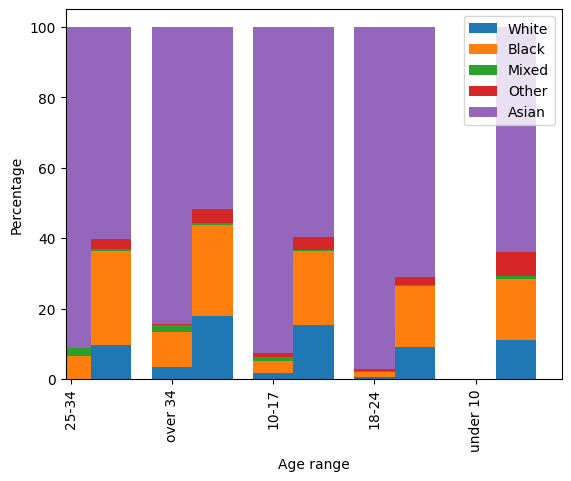

In [19]:
# Calculate the total number of observations per age range for both dataframes
total_per_age_females = df_females.groupby(['Age range'])['observation_id'].count()
total_per_age = df.groupby(['Age range'])['observation_id'].count()

# Create new dataframes to store the percentage of each ethnicity within each age range for both dataframes
df_perc_females = pd.DataFrame(columns=['Age range', 'Officer-defined ethnicity', 'Percentage'])
df_perc = pd.DataFrame(columns=['Age range', 'Officer-defined ethnicity', 'Percentage'])

# Calculate the percentage of each ethnicity within each age range and store it in the new dataframes
for age_range in df_females['Age range'].unique():
    df_age_range = df_females[df_females['Age range'] == age_range]
    total_per_ethnicity = df_age_range.groupby(['Officer-defined ethnicity'])['observation_id'].count()
    for ethnicity in total_per_ethnicity.index:
        perc = total_per_ethnicity[ethnicity] / total_per_age_females[age_range] * 100
        df_perc_females = df_perc_females.append({'Age range': age_range, 'Officer-defined ethnicity': ethnicity, 'Percentage': perc}, ignore_index=True)

for age_range in df['Age range'].unique():
    df_age_range = df[df['Age range'] == age_range]
    total_per_ethnicity = df_age_range.groupby(['Officer-defined ethnicity'])['observation_id'].count()
    for ethnicity in total_per_ethnicity.index:
        perc = total_per_ethnicity[ethnicity] / total_per_age[age_range] * 100
        df_perc = df_perc.append({'Age range': age_range, 'Officer-defined ethnicity': ethnicity, 'Percentage': perc}, ignore_index=True)

# Pivot the dataframes to create plots
df_plot_females = df_perc_females.pivot(index='Age range', columns='Officer-defined ethnicity', values='Percentage')
df_plot = df_perc.pivot(index='Age range', columns='Officer-defined ethnicity', values='Percentage')

# Plot the data
ax = df_plot_females.plot(kind='bar', stacked=True, position=0.5, width=0.4)
df_plot.plot(kind='bar', stacked=True, position=-0.5, width=0.4, ax=ax)

# Modify x-axis labels
ax.set_xticklabels(df['Age range'].unique())

# Modify legend
handles, labels = ax.get_legend_handles_labels()
unique_labels = list(set(labels))
ax.legend(handles[:len(unique_labels)], unique_labels, loc='best')

ax.set_ylabel('Percentage')
ax.set_xlabel('Age range')
plt.show()


In [20]:
df_females = df_rc[(df_rc['Gender'] == 'Female') & (df_rc['Removal of more than just outer clothing'] == True) ]

# Calculate the overall success rate when outer clothing was removed
overall_success_rate = df_females['success'].mean()

# Print the overall success rate
print(f"Overall success rate when outer clothing was removed: {overall_success_rate:.2f}")


Overall success rate when outer clothing was removed: 0.22


In [21]:
df_female = df_rc[(df_rc['Gender'] == 'Female')  &(df_rc['Removal of more than just outer clothing'] == True) ]

threshold = 30

# Create a new dataframe that only includes data that meets the threshold criteria
#df_rc_rate = df_rc_rate.groupby(['Gender', 'Officer-defined ethnicity', 'Age range']).filter(lambda x: len(x) >= threshold)

df_female.groupby(['Gender','Age range','Officer-defined ethnicity'])["success"].count()

Gender  Age range  Officer-defined ethnicity
Female  10-17      Black                          3
                   Mixed                          1
                   White                         42
        18-24      Asian                         11
                   Black                         31
                   Mixed                          6
                   Other                          1
                   White                        265
        25-34      Asian                          8
                   Black                         16
                   Mixed                          5
                   Other                          5
                   White                        428
        over 34    Asian                          3
                   Black                          9
                   Mixed                          2
                   Other                          3
                   White                        590
Name: success, dtyp

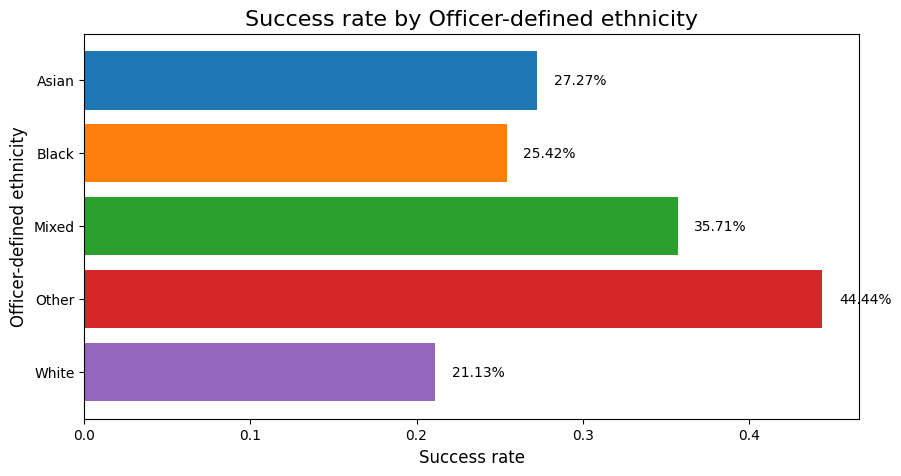

In [22]:
import pandas as pd
import matplotlib.pyplot as plt

# Calculate success rate for each ethnicity
success_rates = df_females.groupby(['Officer-defined ethnicity'])['success'].mean()

# Plot
fig, ax = plt.subplots(figsize=(10,5))

# Set colors for each ethnicity
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

# Loop through each ethnicity and plot the bar
for i, (ethnicity, success_rate) in enumerate(success_rates.items()):
    ax.barh(y=i, width=success_rate, color=colors[i], height=0.8)
    ax.text(success_rate+0.01, i, f'{success_rate*100:.2f}%', ha='left', va='center')

# Set plot title and axis labels
ax.set_title('Success rate by Officer-defined ethnicity', fontsize=16)
ax.set_xlabel('Success rate', fontsize=12)
ax.set_ylabel('Officer-defined ethnicity', fontsize=12)

# Set the yticks to the ethnicity names
ax.set_yticks(range(len(success_rates)))
ax.set_yticklabels(success_rates.index)

# Invert the y-axis to show the ethnicity names from top to bottom
ax.invert_yaxis()

# Show plot
plt.show()


[]


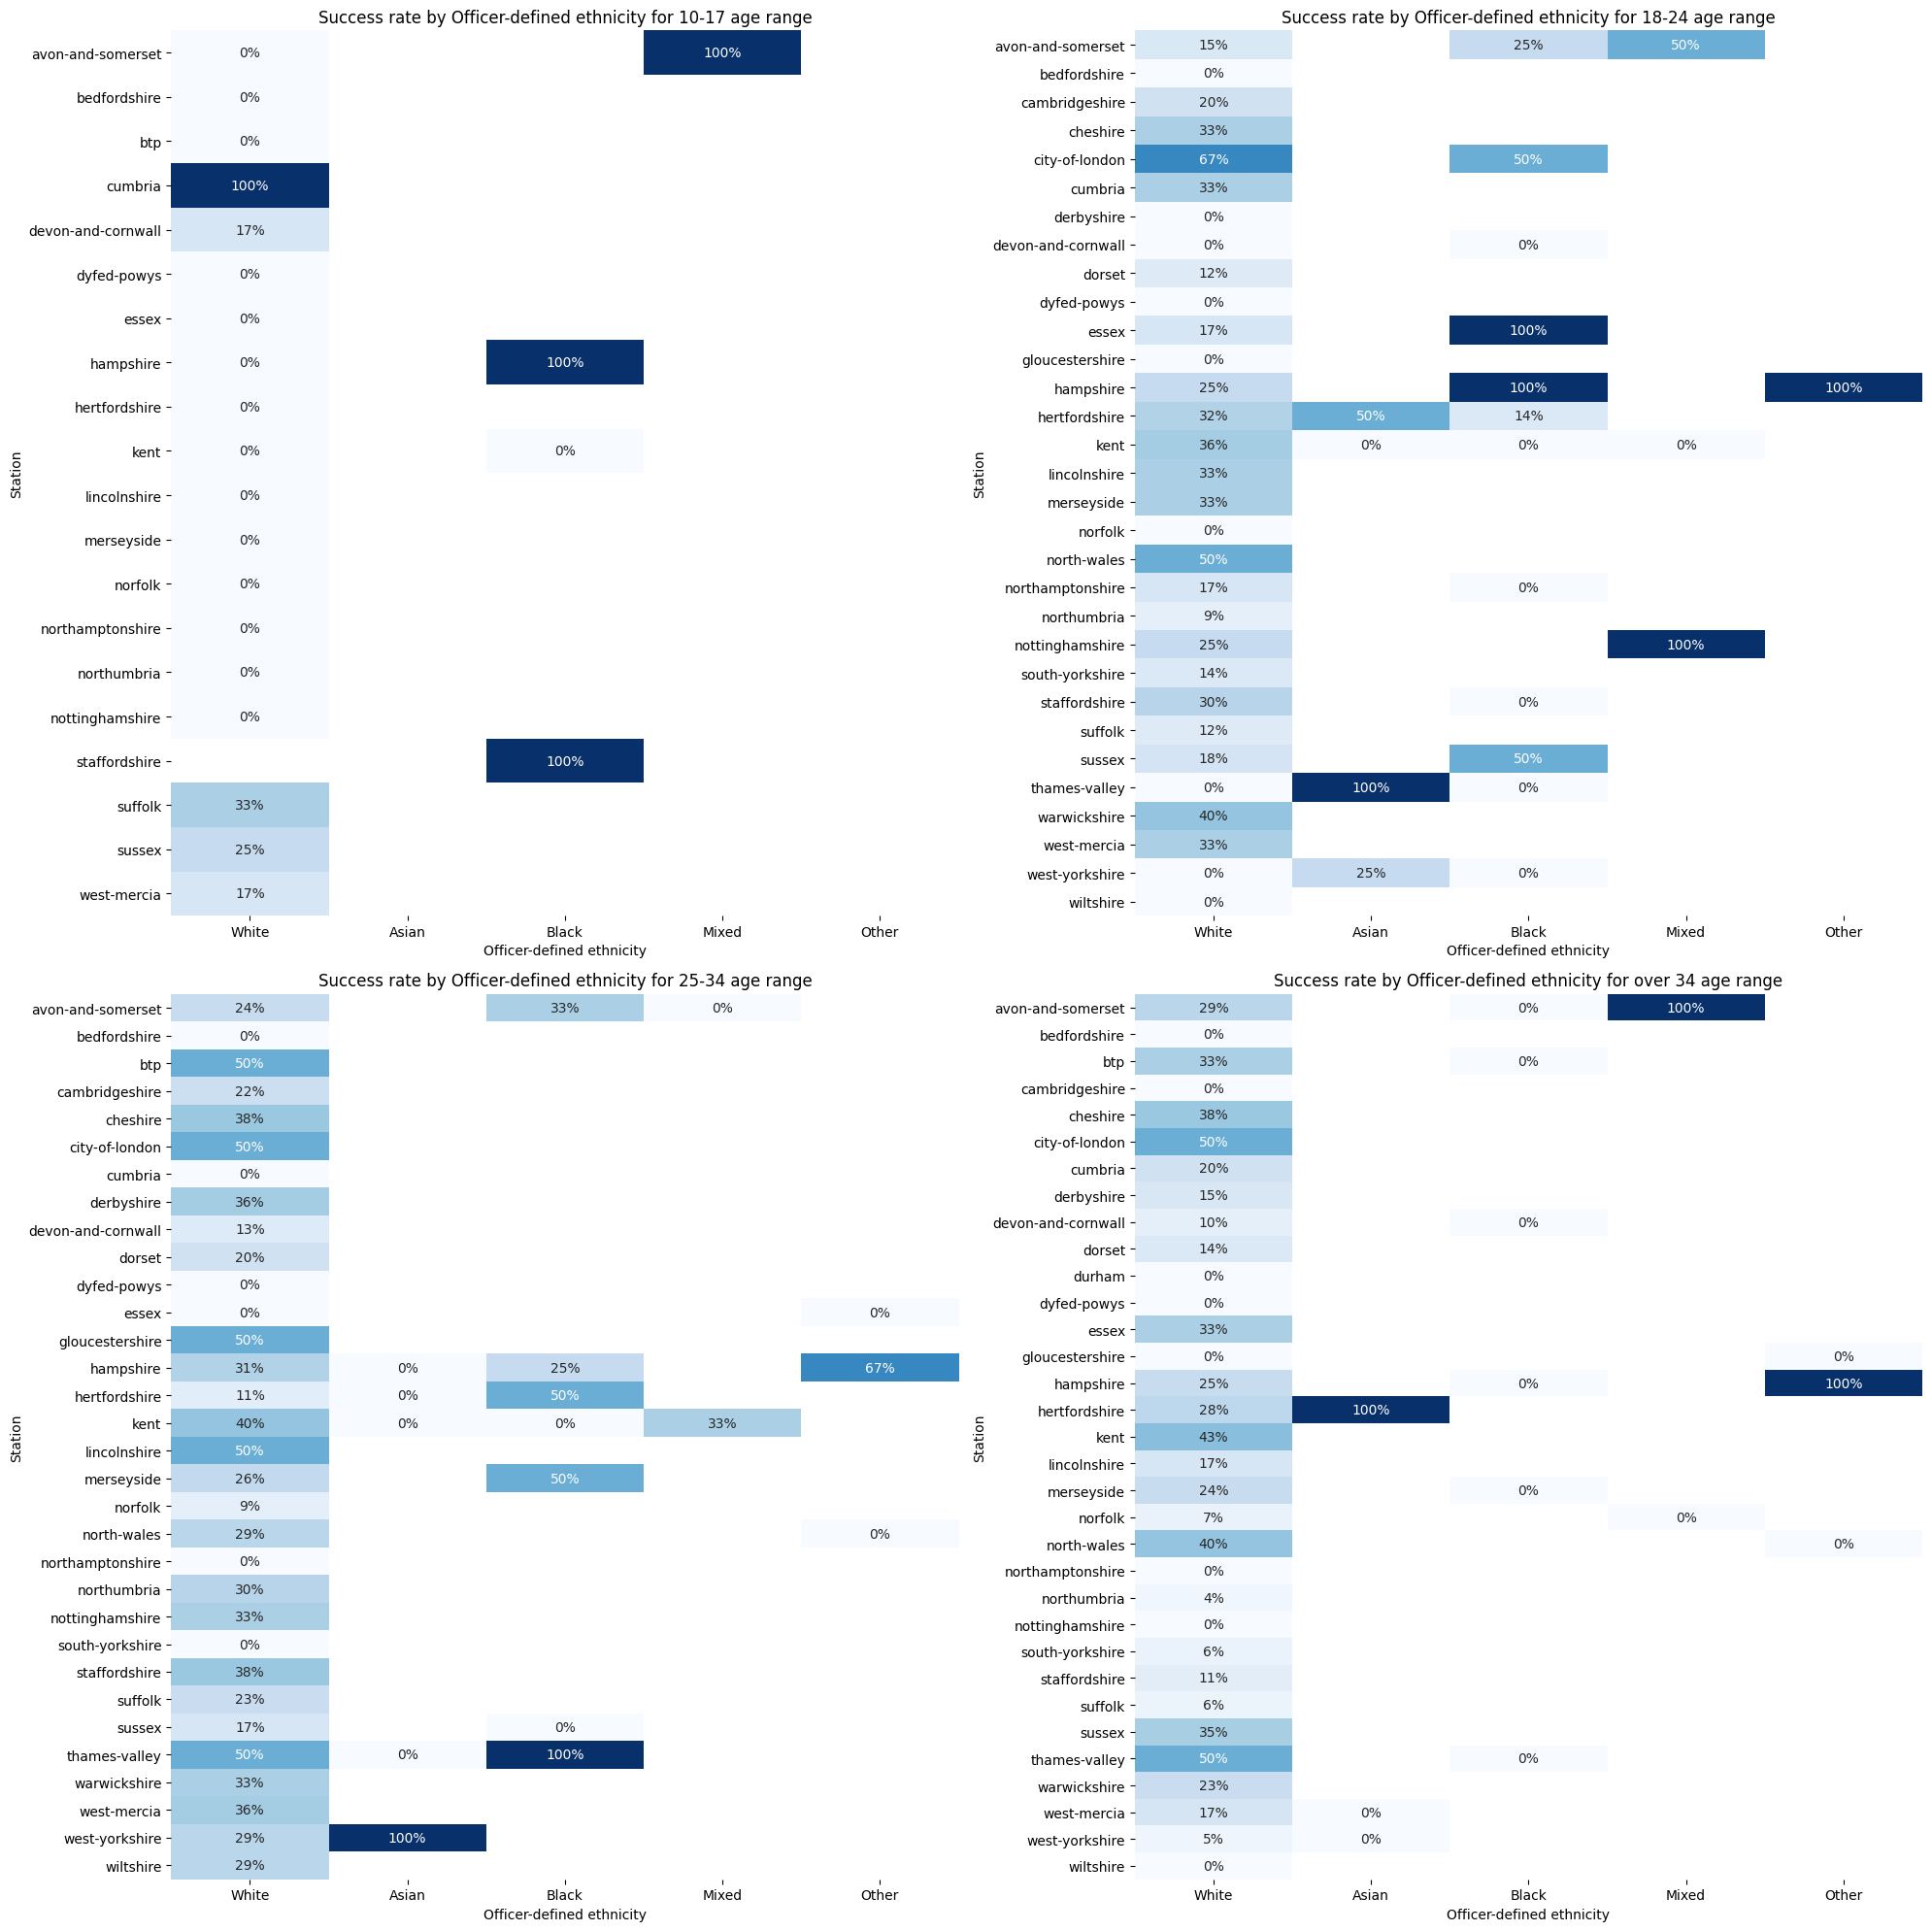

In [23]:
df_filtered = df_females.copy()

# List of age ranges
age_ranges = ['10-17', '18-24', '25-34', 'over 34']

# Order the Officer-defined ethnicity by 'White' first
ethnicity_order = ['White', 'Asian', 'Black', 'Mixed', 'Other']
df_filtered['Officer-defined ethnicity'] = pd.Categorical(df_filtered['Officer-defined ethnicity'], 
                                                          categories=ethnicity_order[::], 
                                                          ordered=True)

# Create subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 20))


problematic_stations = []
for i, ax in enumerate(axes.flatten()):
    # Filter by age range
    df_age = df_filtered[df_filtered['Age range'] == age_ranges[i]]

    # Calculate percentage success for each combination of station and ethnicity
    df_pivot = df_age.groupby(['station', 'Officer-defined ethnicity']).agg({'success': 'mean'}).reset_index().pivot(index='station', columns='Officer-defined ethnicity', values='success')   
    
    # Plot heatmap
    sns.heatmap(df_pivot, cmap='Blues', annot=True, fmt='.0%', cbar=False, ax=ax)
    ax.set_title(f"Success rate by Officer-defined ethnicity for {age_ranges[i]} age range")
    ax.set_xlabel("Officer-defined ethnicity")
    ax.set_ylabel("Station")
print(problematic_stations)
plt.tight_layout()
plt.show()

[]


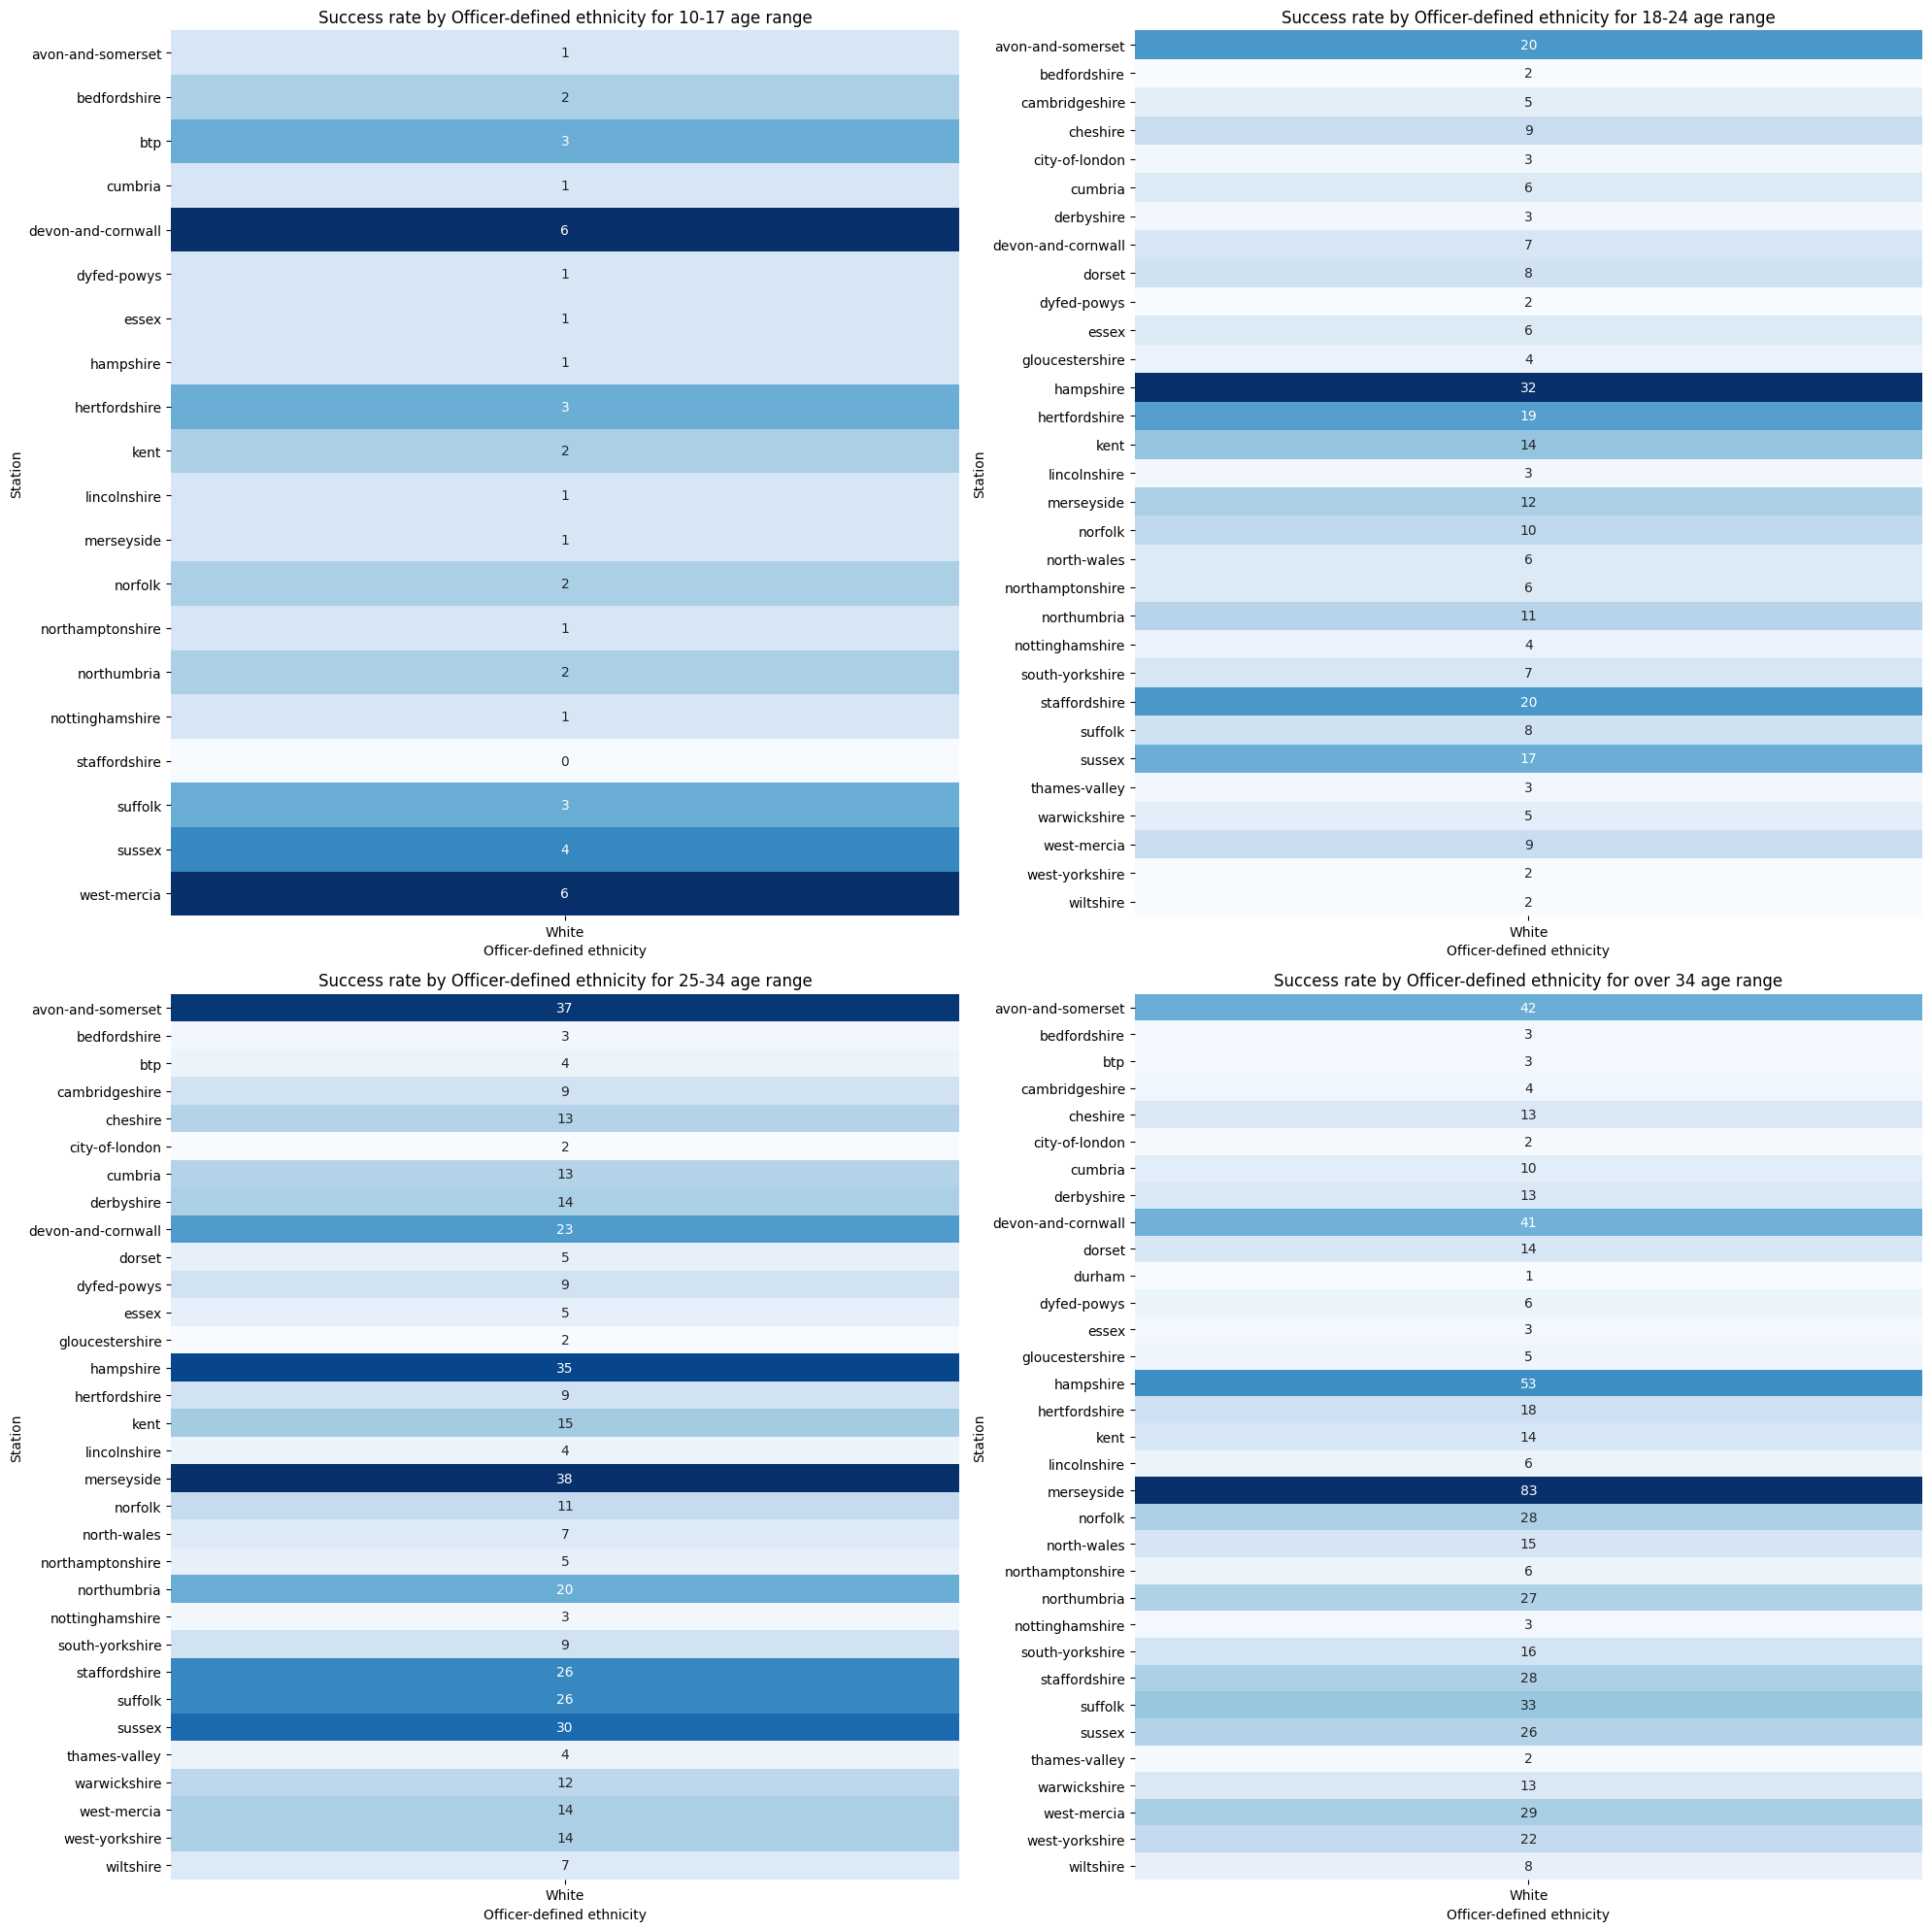

In [24]:


df_filtered = df_females.copy()

# List of age ranges
age_ranges = ['10-17', '18-24', '25-34', 'over 34']

# Order the Officer-defined ethnicity by 'White' first
ethnicity_order = ['White']
df_filtered['Officer-defined ethnicity'] = pd.Categorical(df_filtered['Officer-defined ethnicity'], 
                                                          categories=ethnicity_order[::], 
                                                          ordered=True)

# Create subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 20))


problematic_stations = []
for i, ax in enumerate(axes.flatten()):
    # Filter by age range
    df_age = df_filtered[df_filtered['Age range'] == age_ranges[i]]

    # Calculate percentage success for each combination of station and ethnicity
    df_pivot = df_age.groupby(['station', 'Officer-defined ethnicity'])['observation_id'].count().reset_index().pivot(index='station', columns='Officer-defined ethnicity', values='observation_id')   
    
    # Plot heatmap
    sns.heatmap(df_pivot, cmap='Blues', annot=True, cbar=False, ax=ax)
    ax.set_title(f"Success rate by Officer-defined ethnicity for {age_ranges[i]} age range")
    ax.set_xlabel("Officer-defined ethnicity")
    ax.set_ylabel("Station")
print(problematic_stations)
plt.tight_layout()
plt.show()


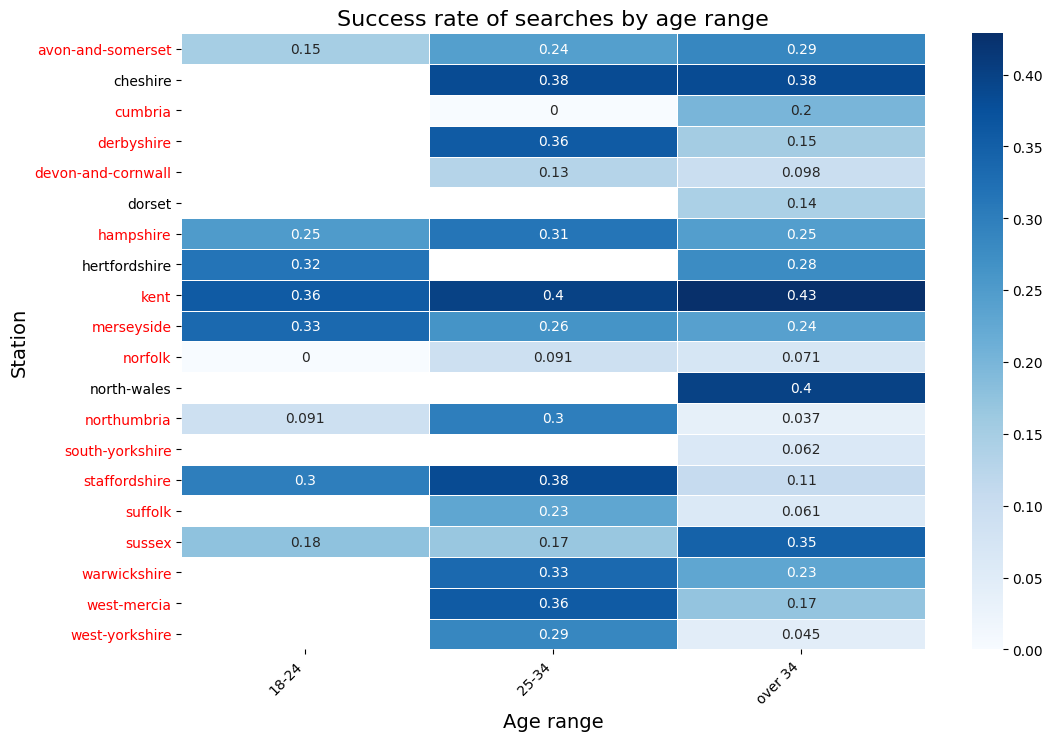

In [25]:
def is_problematic(row):
    max_val = row.max()
    min_val = row.min()
    if row.min() < 0.10 :  return True
    return max_val - min_val > 0.05


data = df_females.copy()

data = data[data['Officer-defined ethnicity'] == 'White']

data = data.groupby(['station', 'Officer-defined ethnicity','Age range']).filter(lambda x : x['observation_id'].count() >= 10 )

data["Age range"] = data["Age range"].astype(str)

# Pivot data
pivot_data = data.pivot_table(index='station', columns="Age range", 
                              values='success', aggfunc='mean')


data_test=  pivot_data.copy()
data_test['problematic'] = data_test.apply(is_problematic, axis=1)

highlight_stations  = data_test[data_test['problematic']].index.tolist()

fig, ax = plt.subplots(figsize=(12,8))
sns.heatmap(pivot_data, annot=True, cmap='Blues', linewidths=.5, ax=ax)


ax.set_title('Success rate of searches by age range', fontsize=16)
ax.set_xlabel('Age range', fontsize=14)

ax.set_ylabel('Station', fontsize=14)

plt.xticks(rotation=45, ha='right')
tick_labels = ax.get_yticklabels()
for label in tick_labels:
    if label.get_text() in highlight_stations:
        label.set_color('red')
    else:
        label.set_color('black')

plt.show()

In [26]:
pivot_data.mean()

Age range
18-24      0.219294
25-34      0.265127
over 34    0.199535
dtype: float64

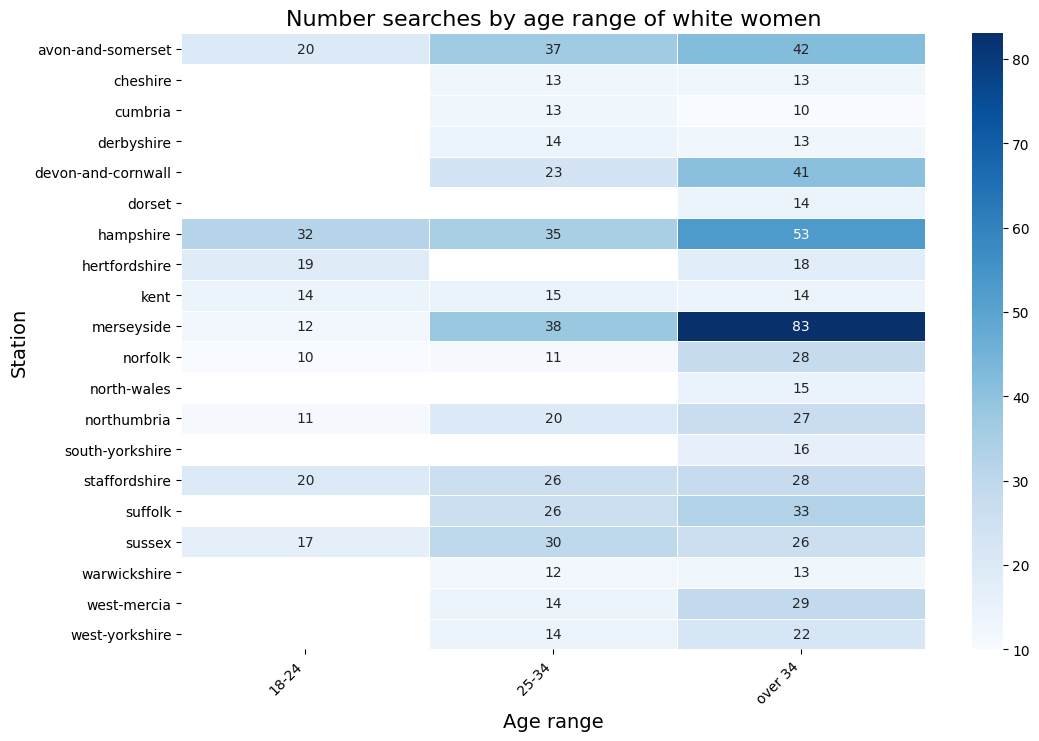

In [27]:
data = df_females.copy()

data = data[data['Officer-defined ethnicity'] == 'White']

data = data.groupby(['station','Age range']).filter(lambda x : x['observation_id'].count() >= 10 )

data["Age range"] = data["Age range"].astype(str)



pivot_data = data.groupby(['station','Age range'])['observation_id'].count().reset_index().pivot(index='station', columns='Age range', values='observation_id')   


fig, ax = plt.subplots(figsize=(12,8))
sns.heatmap(pivot_data, annot=True, cmap='Blues', linewidths=.5, ax=ax)


ax.set_title('Number searches by age range of white women', fontsize=16)
ax.set_xlabel('Age range', fontsize=14)

ax.set_ylabel('Station', fontsize=14)

plt.xticks(rotation=45, ha='right')
plt.show()

In [28]:
# Filter by white females
df_white_females = df_females[df_females['Officer-defined ethnicity'] == 'White']

# Get a list of stations with data for white females
stations_with_data = df_white_females['station'].unique()
stations_with_data

array(['hampshire', 'sussex', 'staffordshire', 'bedfordshire', 'cumbria',
       'warwickshire', 'devon-and-cornwall', 'norfolk', 'kent',
       'wiltshire', 'cheshire', 'btp', 'hertfordshire', 'northumbria',
       'west-yorkshire', 'north-wales', 'gloucestershire',
       'avon-and-somerset', 'suffolk', 'dyfed-powys', 'durham', 'dorset',
       'merseyside', 'derbyshire', 'thames-valley', 'west-mercia',
       'northamptonshire', 'cambridgeshire', 'south-yorkshire',
       'nottinghamshire', 'essex', 'city-of-london', 'lincolnshire'],
      dtype=object)

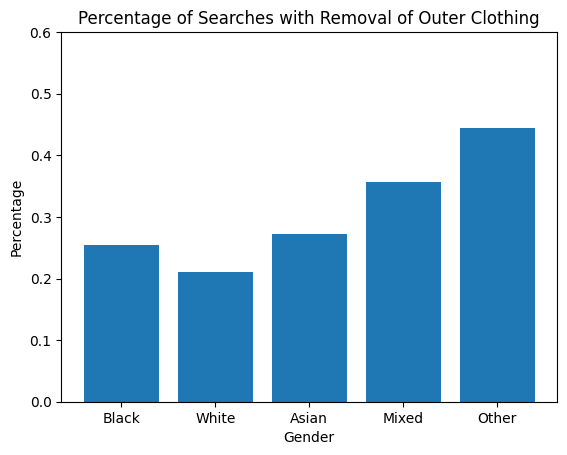

In [29]:
data = df_et.copy()
import matplotlib.pyplot as plt

# Create a subset of data where 'Removal of more than just outer clothing' is True
subset = df_females[(df_females['success'] == 1)]

# Group the subset by gender and count the number of searches
grouped = subset.groupby('Officer-defined ethnicity')['Officer-defined ethnicity'].count()

# Calculate the percentage of searches where outer clothing was removed separately for men and women
women_removed = grouped.loc['Black'] / df_females['Officer-defined ethnicity'].value_counts()['Black']
men_removed = grouped.loc['White'] / df_females['Officer-defined ethnicity'].value_counts()['White']
men_removed1 = grouped.loc['Asian'] / df_females['Officer-defined ethnicity'].value_counts()['Asian']
men_removed2 = grouped.loc['Mixed'] / df_females['Officer-defined ethnicity'].value_counts()['Mixed']
men_removed3 = grouped.loc['Other'] / df_females['Officer-defined ethnicity'].value_counts()['Other']

# Plot the results
plt.bar(['Black', 'White',"Asian",'Mixed',"Other"], [women_removed, men_removed,men_removed1,men_removed2,men_removed3])
plt.title('Percentage of Searches with Removal of Outer Clothing')
plt.xlabel('Gender')
plt.ylabel('Percentage')
plt.ylim(0, 0.6)
plt.show()


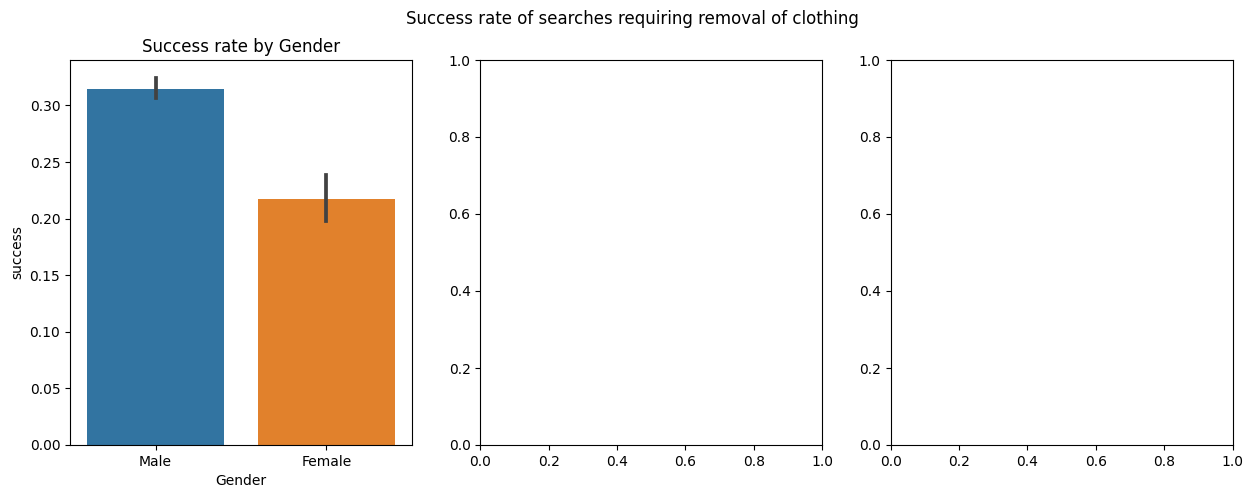

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select relevant columns
data = df_rc[['Gender', "Officer-defined ethnicity", 'Age range', 'Removal of more than just outer clothing', 'success']]

# Filter the data to only include searches where removal of clothing was necessary
data = data[data['Removal of more than just outer clothing'] == True]

# Create subplots
fig, axs = plt.subplots(ncols=3, figsize=(15,5))

# Plot 1: success rate by gender
sns.barplot(x='Gender', y='success', data=data, ax=axs[0])
axs[0].set_title('Success rate by Gender')

fig.suptitle('Success rate of searches requiring removal of clothing')

plt.show()


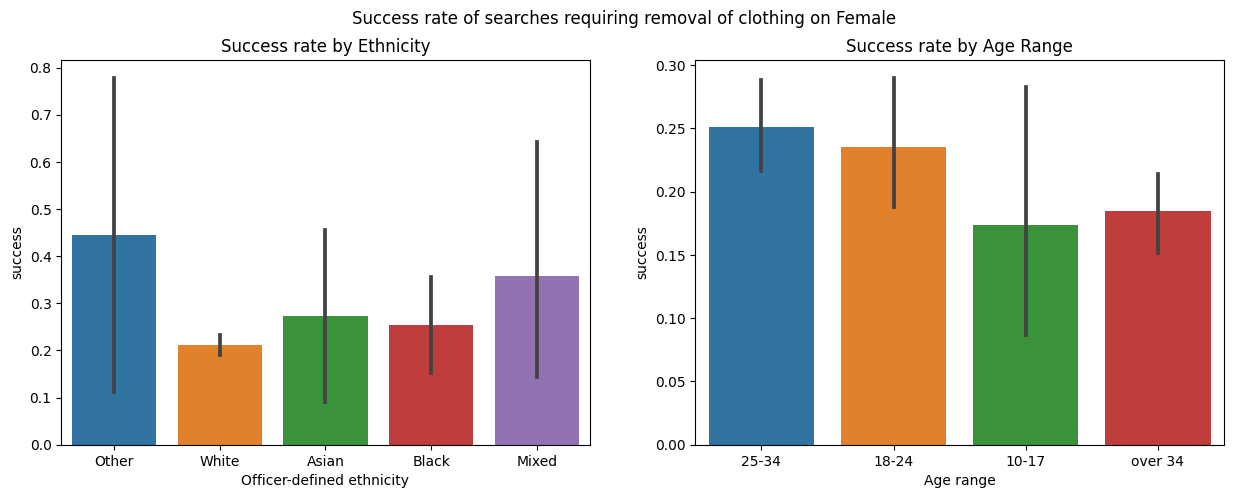

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select relevant columns
data = df_rc[['Gender', "Officer-defined ethnicity", 'Age range', 'Removal of more than just outer clothing', 'success']]

# Filter the data to only include searches where removal of clothing was necessary
data = data[(data['Removal of more than just outer clothing'] == True) & (data['Gender'] == 'Female')]

# Create subplots
fig, axs = plt.subplots(ncols=2, figsize=(15,5))


# Plot 2: success rate by ethnicity
sns.barplot(x='Officer-defined ethnicity', y='success', data=data, ax=axs[0])
axs[0].set_title('Success rate by Ethnicity')

# Plot 3: success rate by age range
sns.barplot(x='Age range', y='success', data=data, ax=axs[1])
axs[1].set_title('Success rate by Age Range')

# Set the overall title of the figure
fig.suptitle('Success rate of searches requiring removal of clothing on Female')

plt.show()


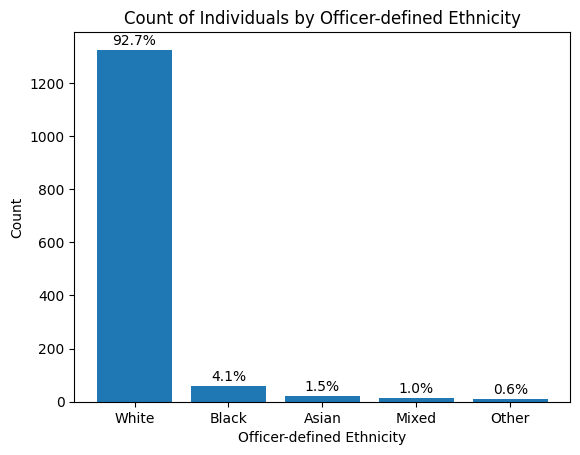

In [32]:
ethnicity_counts = data['Officer-defined ethnicity'].value_counts()
total_count = ethnicity_counts.sum()
plt.bar(ethnicity_counts.index, ethnicity_counts.values)
plt.title('Count of Individuals by Officer-defined Ethnicity')
plt.xlabel('Officer-defined Ethnicity')
plt.ylabel('Count')

# loop through each bar and add the percentage value on top
for i, count in enumerate(ethnicity_counts):
    percentage = count / total_count * 100
    plt.text(i, count + 20, f'{percentage:.1f}%', ha='center')

plt.show()


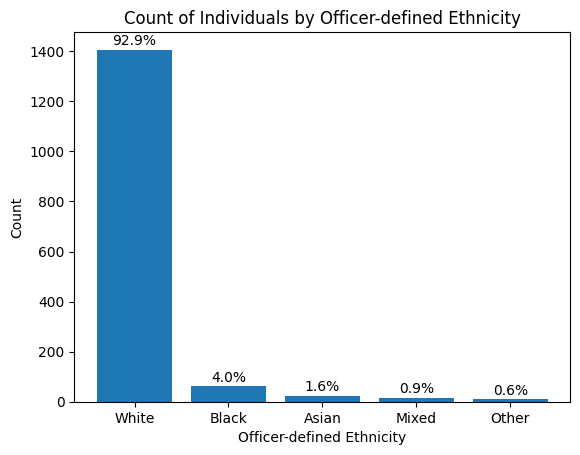

In [33]:
bla = df[(df['Removal of more than just outer clothing'] == True) & (df['Gender'] == 'Female')]

ethnicity_counts =bla['Officer-defined ethnicity'].value_counts()
total_count = ethnicity_counts.sum()
plt.bar(ethnicity_counts.index, ethnicity_counts.values)
plt.title('Count of Individuals by Officer-defined Ethnicity')
plt.xlabel('Officer-defined Ethnicity')
plt.ylabel('Count')

# loop through each bar and add the percentage value on top
for i, count in enumerate(ethnicity_counts):
    percentage = count / total_count * 100
    plt.text(i, count + 20, f'{percentage:.1f}%', ha='center')

plt.show()
